In [1]:
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as pchs
from matplotlib.patches import Patch
import numpy as np
import os
import scipy
from scipy import stats
import seaborn as sb

In [2]:
def openFiles(path):
    
    times = []
    dists = []
    fileNum = 0
    sizes = []
    
    for files in os.scandir(path):
        
        data = open(files, 'r')
        blanks = 0
        fileTimes = []
        fileDists = []
        
        for line in data.readlines():
            
            iData = line.split()
            valueWorks = True
            
            try:
                float(iData[0])
            except:
                valueWorks = False
            
            if valueWorks == True:
                value = float(iData[0])
                if blanks == 1:
                    fileTimes.append(value/60)
                elif blanks == 2:
                    fileDists.append(value)
            
            else:
                blanks += 1
        
        times.append(fileTimes)
        dists.append(fileDists)
        sizes.append(len(fileTimes))
        fileNum += 1
        
    longVid = max(sizes)
    longList = 0
    
    for i in range(fileNum):
        if len(times[i]) == longVid:
            longList = i
    
    return(times, dists, longVid)




def resetTs(oldTs, possibleTs):
    
    newTs = []
    
    for i in range(len(oldTs)):
        
        oldTsI = oldTs[i]
        newTsI = []
        timeDiff = (oldTsI[len(oldTsI)-1]-oldTsI[0])/(len(oldTsI)-1)
        realT = 0
        
        for j in range(len(possibleTs)):
            if abs(60*timeDiff-possibleTs[j]) < 0.25:
                realT = possibleTs[j]
        
        for j in range(len(oldTsI)):
            newTsI.append(j*realT/60)
        
        newTs.append(newTsI)
    
    return(newTs)




def combineData(times, data):
    
    allTimes = []
    allData = []
    
    for i in range(len(data)):
        
        timesI = times[i]
        dataI = data[i]
        
        for j in range(len(dataI)):
            allTimes.append(timesI[j])
            allData.append(dataI[j])
    
    return(allTimes, allData)




def equalFRs(times, data, frameRate, threshold):
    
    timesFR = []
    dataFR = []
    
    for i in range(len(times)):
        
        timesI = times[i]
        dataI = data[i]
        
        if abs(timesI[1]-timesI[0]-frameRate) < threshold:
            timesFR.append(timesI)
            dataFR.append(dataI)
        
        else:
            
            timesFRi = []
            dataFRi = []
            dataTot = []
            maxTi = round(timesI[len(timesI)-1]/frameRate)+1
            
            for j in range(maxTi):
                timesFRi.append(j*frameRate)
                dataTot.append([])
            
            for j in range(len(timesI)):
                if timesI[1]-timesI[0]>frameRate and abs(abs(timesI[j]/frameRate-int(timesI[j]/frameRate))-0.5)<0.1:
                    dataTot[int(timesI[j]/frameRate)].append(dataI[j])
                    if int(timesI[j]/frameRate)+1 < len(dataTot):
                        dataTot[int(timesI[j]/frameRate)+1].append(dataI[j])
                else:
                    dataTot[round(timesI[j]/frameRate)].append(dataI[j])
            
            for j in range(maxTi):
                dataFRi.append(np.mean(dataTot[j]))
            
            timesFR.append(timesFRi)
            dataFR.append(dataFRi)
    
    return(timesFR, dataFR)




def smoothen(times, dists, order):
    
    orders = []
    longOrder = 0
    
    for i in range(len(times)):
        orders.append(int(round(math.sqrt(order)/(times[i][1]-times[i][0]))))
    
    for i in range(len(orders)):
        if orders[i]>longOrder:
            longOrder = orders[i]
    
    smoothDists = []
    smooths = []
    counter = 0
    
    for i in range(len(dists)):
        
        smoothDists.append([])
        smooths.append([])
        
        for j in range(len(dists[i])):
            
            smoothDists[i].append(dists[i][j])
    
    while counter<longOrder:
        
        for i in range(len(smoothDists)):
            
            if counter<orders[i]:
                
                smooths.append([])
                
                smoothL0 = (20*smoothDists[i][0] + 15*smoothDists[i][1] + 6*smoothDists[i][2] + smoothDists[i][3])/42
                smoothL1 = (15*smoothDists[i][0] + 20*smoothDists[i][1] + 15*smoothDists[i][2] + 6*smoothDists[i][3] + smoothDists[i][4])/57
                smoothL2 = (6*smoothDists[i][0] + 15*smoothDists[i][1] + 20*smoothDists[i][2] + 15*smoothDists[i][3] + 6*smoothDists[i][4] + smoothDists[i][5])/63
                
                smooths[i].append(smoothL0)
                smooths[i].append(smoothL1)
                smooths[i].append(smoothL2)
                
                for j in range(3,len(smoothDists[i])-3):
                    smoothLI = (smoothDists[i][j-3] + 6*smoothDists[i][j-2] + 15*smoothDists[i][j-1] + 20*smoothDists[i][j] + 15*smoothDists[i][j+1] + 6*smoothDists[i][j+2] + smoothDists[i][j+3])/64
                    smooths[i].append(smoothLI)
                
                smoothLM2 = (smoothDists[i][len(dists[i])-6] + 6*smoothDists[i][len(dists[i])-5] + 15*smoothDists[i][len(dists[i])-4] + 20*smoothDists[i][len(dists[i])-3] + 15*smoothDists[i][len(dists[i])-2] + 6*smoothDists[i][len(dists[i])-1])/63
                smoothLM1 = (smoothDists[i][len(dists[i])-5] + 6*smoothDists[i][len(dists[i])-4] + 15*smoothDists[i][len(dists[i])-3] + 20*smoothDists[i][len(dists[i])-2] + 15*smoothDists[i][len(dists[i])-1])/57
                smoothLM0 = (smoothDists[i][len(dists[i])-4] + 6*smoothDists[i][len(dists[i])-3] + 15*smoothDists[i][len(dists[i])-2] + 20*smoothDists[i][len(dists[i])-1])/42
                
                smooths[i].append(smoothLM2)
                smooths[i].append(smoothLM1)
                smooths[i].append(smoothLM0)
            
            else:
                smooths.append([])
                for j in range(len(smoothDists[i])):
                    smooths[i].append(smoothDists[i][j])
            
            smoothDists[i].clear()
            
            for j in range(len(smooths[i])):
                smoothDists[i].append(smooths[i][j])
        
        smooths.clear()
        counter += 1
        
    return(smoothDists)




def dMax(times, dists):
    
    maxTimes = []
    maxDists = []
    
    for i in range(len(times)):
        
        maxTimeI = 0
        maxDistsI = 0
        
        for j in range(len(times[i])):
            if dists[i][j]>maxDistsI:
                maxTimeI = times[i][j]
                maxDistsI = dists[i][j]
        
        maxTimes.append(maxTimeI)
        maxDists.append(maxDistsI)
    
    return(maxTimes, maxDists)




def vMax(times, dists):
    
    vs = []
    maxVTs = []
    maxVs = []
    
    for i in range(len(times)):
        
        vs.append([])
        maxTI = 0
        maxVI = 0
        
        for j in range(len(times[i])):
            
            if j==0:
                Vij = -(dists[i][1]-dists[i][0])/(times[i][1]/60-times[i][0]/60)
            elif j==len(times[i])-1:
                Vij = -(dists[i][j]-dists[i][j-1])/(times[i][j]/60-times[i][j-1]/60)
            else:
                Vij = -(dists[i][j+1]-dists[i][j-1])/(times[i][j+1]/60-times[i][j-1]/60)
            
            if Vij>maxVI:
                maxTI = times[i][j]
                maxVI = Vij
            
            vs[i].append(Vij)
        
        maxVTs.append(maxTI)
        maxVs.append(maxVI)
    
    return(vs, maxVTs, maxVs)




def swarm(namesIn, timesIn, dataIn):
    
    names = []
    times = []
    data = []
    
    for i in range(len(timesIn)):
        
        namesI = namesIn[i]
        timesI = timesIn[i]
        dataI = dataIn[i]
        
        for j in range(len(timesI)):
            names.append(namesI)
            times.append(timesI[j])
            data.append(dataI[j])
    
    return(names, times, data)




def boxes(names, data):
    
    types = []
    std = []
    error = []
    
    for i in range(len(data)):
        dataI = data[i]
        types.append(names[i])
        std.append([np.mean(dataI), np.mean(dataI)-2*np.std(dataI), np.mean(dataI)+2*np.std(dataI)])
        error.append([np.mean(dataI), np.mean(dataI)-2*np.std(dataI)/np.sqrt(len(dataI)), np.mean(dataI)+2*np.std(dataI)/np.sqrt(len(dataI))])
    
    return(types, std, error)




def dCKD(dists):
    
    dCKDs = []
    
    for i in range(len(dists)):
        dCKDsI = []
        for j in range(len(dists[i])):
            dCKDsI.append(dists[i][j]-dists[i][0])
        dCKDs.append(dCKDsI)
    
    return(dCKDs)




def runType(timesIn, distsIn, frameRate, threshold, possibleTs):
    
    times, dists = combineData(timesIn, distsIn)
    times = resetTs(times, possibleTs)
    
    dckds = dCKD(dists)
    dckds10 = smoothen(times, dckds, 10)
    timesFR, dckdsFR = equalFRs(times, dckds, frameRate, threshold)
    
    maxDTs, maxDs = dMax(times, dckds)
    maxDTs10, maxDs10 = dMax(times, dckds10)
    maxDTsFR, maxDsFR = dMax(timesFR, dckdsFR)
    
    vs, maxVTs, maxVs = vMax(times, dckds)
    vs10, maxVTs10, maxVs10 = vMax(times, dckds10)
    vsFR, maxVTsFR, maxVsFR = vMax(timesFR, dckdsFR)
    
    return(times, timesFR, dckds, dckds10, dckdsFR, maxDTs, maxDs, vs, maxVTs, maxVs, maxDTs10, maxDs10, vs10, maxVTs10, maxVs10, maxDTsFR, maxDsFR, vsFR, maxVTsFR, maxVsFR)




def swarmD(names, maxDTs, maxDs, maxDTs10, maxDs10, maxDTsFR, maxDsFR):
    
    swarmTypes, swarmTs, swarmDs = swarm(names, maxDTs, maxDs)
    swarmTypes10, swarmTs10, swarmDs10 = swarm(names, maxDTs10, maxDs10)
    swarmTypesFR, swarmTsFR, swarmDsFR = swarm(names, maxDTsFR, maxDsFR)
    
    tBoxTypes, tSBox, tEBox = boxes(names, maxDTs)
    tBoxTypes10, tSBox10, tEBox10 = boxes(names, maxDTs10)
    tBoxTypesFR, tSBoxFR, tEBoxFR = boxes(names, maxDTsFR)
    
    return(swarmTypes, swarmTs, tBoxTypes, tEBox, swarmTypes10, swarmTs10, tBoxTypes10, tEBox10, swarmTypesFR, swarmTsFR, tBoxTypesFR, tEBoxFR)




def swarmV(names, maxVTs, maxVs, maxVTs10, maxVs10, maxVTsFR, maxVsFR):
    
    swarmTypesV, swarmVTs, swarmVs = swarm(names, maxVTs, maxVs)
    swarmTypesV10, swarmVTs10, swarmVs10 = swarm(names, maxVTs10, maxVs10)
    swarmTypesVFR, swarmVTsFR, swarmVsFR = swarm(names, maxVTsFR, maxVsFR)
    
    vBoxTypes, vSBox, vEBox = boxes(names, maxVs)
    vBoxTypes10, vSBox10, vEBox10 = boxes(names, maxVs10)
    vBoxTypesFR, vSBoxFR, vEBoxFR = boxes(names, maxVsFR)
    
    return(swarmTypesV, swarmVs, vBoxTypes, vEBox, swarmTypesV10, swarmVs10, vBoxTypes10, vEBox10, swarmTypesVFR, swarmVsFR, vBoxTypesFR, vEBoxFR)




def pVals(maxDTs, maxDs, maxVTs, maxVs, maxDTs10, maxDs10, maxVTs10, maxVs10, maxDTsFR, maxDsFR, maxVTsFR, maxVsFR):
    
    inputLists = [maxDTs, maxDs, maxVTs, maxVs, maxDTs10, maxDs10, maxVTs10, maxVs10, maxDTsFR, maxDsFR, maxVTsFR, maxVsFR]
    outputLists = []
    
    for i in range(len(inputLists)):
        inputI = inputLists[i]
        psI = []
        for j in range(len(inputI)-1):
            t, p = scipy.stats.ttest_ind(inputI[0], inputI[j+1])
            psI.append(p)
        outputLists.append(psI)
    
    dtPs = outputLists[0]
    dPs = outputLists[1]
    vtPs = outputLists[2]
    vPs = outputLists[3]
    dtPs10 = outputLists[4]
    dPs10 = outputLists[5]
    vtPs10 = outputLists[6]
    vPs10 = outputLists[7]
    dtPsFR = outputLists[8]
    dPsFR = outputLists[9]
    vtPsFR = outputLists[10]
    vPsFR = outputLists[11]
    
    return(dtPs, dPs, vtPs, vPs, dtPs10, dPs10, vtPs10, vPs10, dtPsFR, dPsFR, vtPsFR, vPsFR)




def timeData(times, data, T):
    
    avgTimes = []
    avgDs = []
    lowDs = []
    highDs = []
    
    for i in range(len(times)):
        
        avgTimesI = []
        avgDsI = []
        lowDsI = []
        highDsI = []
        
        timesI = times[i]
        dataI = data[i]
        N = len(timesI)
        condenseDs = []
        
        maxT = 0
        for j in range(N):
            if timesI[j][len(timesI[j])-1] > maxT:
                maxT = timesI[j][len(timesI[j])-1]
        
        for j in range(N):
            
            condenseIJ = []
            timesIJ = timesI[j]
            dataIJ = dataI[j]
            timeDiff = timesIJ[1]
            frames = int(maxT/timeDiff+1)
            distance = 0
            counter = 0
            holdD = 0
            holding = False
            
            for k in range(frames):
                
                if k < len(timesIJ):
                    distance = -dataIJ[k]
                
                if timeDiff > T:
                    if holding == True:
                        condenseIJ.append((holdD+distance)/2)
                        condenseIJ.append(distance)
                        counter += 2
                        holdD = 0
                        holding = False
                    elif abs(k*timeDiff-counter*T) > T/3:
                        condenseIJ.append(distance)
                        counter += 1
                        holdD = distance
                        holding = True
                    else:
                        condenseIJ.append(distance)
                        counter += 1
                        holdD = 0
                        holding = False
                
                else:
                    if abs(k*timeDiff-counter*T) < timeDiff/2:
                        condenseIJ.append(distance)
                        counter += 1
                        holdD = 0
                        holding = False
                    elif abs(abs(k*timeDiff-counter*T)-timeDiff/2) < 0.00000001/60:
                        if holding == True:
                            condenseIJ.append((holdD+distance)/2)
                            holdD = 0
                            counter += 1
                            holding = False
                        else:
                            holdD = distance
                            holding = True
                    else:
                        holdD = 0
                        holding = False
            
            if maxT/timeDiff >= int(maxT/timeDiff)+0.5:
                condenseIJ.append(distance*timeDiff/60)
            
            condenseDs.append(condenseIJ)
        
        for j in range(len(condenseDs[0])):
            
            combineDs = []
            for k in range(N):
                if len(condenseDs[k]) < len(condenseDs[0]):
                    condenseDs[k].append(condenseDs[k][len(condenseDs[k])-1])
                combineDs.append(condenseDs[k][j])
            
            avgTimesI.append(j*T)
            avgD = np.mean(combineDs)
            eI = np.std(combineDs)/math.sqrt(len(combineDs))
            avgDsI.append(avgD)
            lowDsI.append(avgD-eI)
            highDsI.append(avgD+eI)
        
        avgTimes.append(avgTimesI)
        avgDs.append(avgDsI)
        lowDs.append(lowDsI)
        highDs.append(highDsI)
    
    return(avgTimes, avgDs, lowDs, highDs)

In [3]:
names = ['Control', 'Nocodazole', 'Numa siRNA', 'STLC', 'Kif15-IN-1', 'GW108X']
frameRate = 3.5/60
threshold = 0.1/60
possibleTs = [0.28, 1, 2, 3, 3.5, 4]

WTtimes, WTdists, WTlong = openFiles(path=r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\Fibers\Control\Good\Final')
NDZtimes, NDZdists, NDZlong = openFiles(path=r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\Fibers\Nocodazole\Good\Final')
NuMAtimes, NuMAdists, NuMAlong = openFiles(path=r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\Fibers\NuMA\NuMA-siRNA\Good')
STLCtimes, STLCdists, STLClong = openFiles(path=r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\Fibers\Eg5\STLC\Good')
KN1times, KN1dists, KN1long = openFiles(path=r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\Fibers\Kif15\Kif15-IN-1\Good\Final')
GWXtimes, GWXdists, GWXlong = openFiles(path=r'E:\KFiberSplaying\AblationExperiments\JupyterOutput\Paper\Fibers\Kif15\GW108X\Good\Final')
WTtimesIn = [WTtimes]
WTdistsIn = [WTdists]
NDZtimesIn = [NDZtimes]
NDZdistsIn = [NDZdists]
NuMAtimesIn = [NuMAtimes]
NuMAdistsIn = [NuMAdists]
STLCtimesIn = [STLCtimes]
STLCdistsIn = [STLCdists]
KN1timesIn = [KN1times]
KN1distsIn = [KN1dists]
GWXtimesIn = [GWXtimes]
GWXdistsIn = [GWXdists]

WTtimes, WTtimesFR, WTdckds, WTdckds10, WTdckdsFR, WTmaxDTs, WTmaxDs, WTvs, WTmaxVTs, WTmaxVs, WTmaxDTs10, WTmaxDs10, WTvs10, WTmaxVTs10, WTmaxVs10, WTmaxDTsFR, WTmaxDsFR, WTvsFR, WTmaxVTsFR, WTmaxVsFR = runType(WTtimesIn, WTdistsIn, frameRate, threshold, possibleTs)
NDZtimes, NDZtimesFR, NDZdckds, NDZdckds10, NDZdckdsFR, NDZmaxDTs, NDZmaxDs, NDZvs, NDZmaxVTs, NDZmaxVs, NDZmaxDTs10, NDZmaxDs10, NDZvs10, NDZmaxVTs10, NDZmaxVs10, NDZmaxDTsFR, NDZmaxDsFR, NDZvsFR, NDZmaxVTsFR, NDZmaxVsFR = runType(NDZtimesIn, NDZdistsIn, frameRate, threshold, possibleTs)
NuMAtimes, NuMAtimesFR, NuMAdckds, NuMAdckds10, NuMAdckdsFR, NuMAmaxDTs, NuMAmaxDs, NuMAvs, NuMAmaxVTs, NuMAmaxVs, NuMAmaxDTs10, NuMAmaxDs10, NuMAvs10, NuMAmaxVTs10, NuMAmaxVs10, NuMAmaxDTsFR, NuMAmaxDsFR, NuMAvsFR, NuMAmaxVTsFR, NuMAmaxVsFR = runType(NuMAtimesIn, NuMAdistsIn, frameRate, threshold, possibleTs)
STLCtimes, STLCtimesFR, STLCdckds, STLCdckds10, STLCdckdsFR, STLCmaxDTs, STLCmaxDs, STLCvs, STLCmaxVTs, STLCmaxVs, STLCmaxDTs10, STLCmaxDs10, STLCvs10, STLCmaxVTs10, STLCmaxVs10, STLCmaxDTsFR, STLCmaxDsFR, STLCvsFR, STLCmaxVTsFR, STLCmaxVsFR = runType(STLCtimesIn, STLCdistsIn, frameRate, threshold, possibleTs)
KN1times, KN1timesFR, KN1dckds, KN1dckds10, KN1dckdsFR, KN1maxDTs, KN1maxDs, KN1vs, KN1maxVTs, KN1maxVs, KN1maxDTs10, KN1maxDs10, KN1vs10, KN1maxVTs10, KN1maxVs10, KN1maxDTsFR, KN1maxDsFR, KN1vsFR, KN1maxVTsFR, KN1maxVsFR = runType(KN1timesIn, KN1distsIn, frameRate, threshold, possibleTs)
GWXtimes, GWXtimesFR, GWXdckds, GWXdckds10, GWXdckdsFR, GWXmaxDTs, GWXmaxDs, GWXvs, GWXmaxVTs, GWXmaxVs, GWXmaxDTs10, GWXmaxDs10, GWXvs10, GWXmaxVTs10, GWXmaxVs10, GWXmaxDTsFR, GWXmaxDsFR, GWXvsFR, GWXmaxVTsFR, GWXmaxVsFR = runType(GWXtimesIn, GWXdistsIn, frameRate, threshold, possibleTs)

maxDTs = [WTmaxDTs, NDZmaxDTs, NuMAmaxDTs, STLCmaxDTs, KN1maxDTs, GWXmaxDTs]
maxDs = [WTmaxDs, NDZmaxDs, NuMAmaxDs, STLCmaxDs, KN1maxDs, GWXmaxDs]
maxDTs10 = [WTmaxDTs10, NDZmaxDTs10, NuMAmaxDTs10, STLCmaxDTs10, KN1maxDTs10, GWXmaxDTs10]
maxDs10 = [WTmaxDs10, NDZmaxDs10, NuMAmaxDs10, STLCmaxDs10, KN1maxDs10, GWXmaxDs10]
maxDTsFR = [WTmaxDTsFR, NDZmaxDTsFR, NuMAmaxDTsFR, STLCmaxDTsFR, KN1maxDTsFR, GWXmaxDTsFR]
maxDsFR = [WTmaxDsFR, NDZmaxDsFR, NuMAmaxDsFR, STLCmaxDsFR, KN1maxDsFR, GWXmaxDsFR]

maxVTs = [WTmaxVTs, NDZmaxVTs, NuMAmaxVTs, STLCmaxVTs, KN1maxVTs, GWXmaxVTs]
maxVs = [WTmaxVs, NDZmaxVs, NuMAmaxVs, STLCmaxVs, KN1maxVs, GWXmaxVs]
maxVTs10 = [WTmaxVTs10, NDZmaxVTs10, NuMAmaxVTs10, STLCmaxVTs10, KN1maxVTs10, GWXmaxVTs10]
maxVs10 = [WTmaxVs10, NDZmaxVs10, NuMAmaxVs10, STLCmaxVs10, KN1maxVs10, GWXmaxVs10]
maxVTsFR = [WTmaxVTsFR, NDZmaxVTsFR, NuMAmaxVTsFR, STLCmaxVTsFR, KN1maxVTsFR, GWXmaxVTsFR]
maxVsFR = [WTmaxVsFR, NDZmaxVsFR, NuMAmaxVsFR, STLCmaxVsFR, KN1maxVsFR, GWXmaxVsFR]

ts = [WTtimes, NDZtimes, NuMAtimes, STLCtimes, KN1times, GWXtimes]
dckds = [WTdckds, NDZdckds, NuMAdckds, STLCdckds, KN1dckds, GWXdckds]

swarmTypes, swarmTs, tBoxTypes, tEBox, swarmTypes10, swarmTs10, tBoxTypes10, tEBox10, swarmTypesFR, swarmTsFR, tBoxTypesFR, tEBoxFR = swarmD(names, maxDTs, maxDs, maxDTs10, maxDs10, maxDTsFR, maxDsFR)
swarmTypesV, swarmVs, vBoxTypes, vEBox, swarmTypesV10, swarmVs10, vBoxTypes10, vEBox10, swarmTypesVFR, swarmVsFR, vBoxTypesFR, vEBoxFR = swarmV(names, maxVTs, maxVs, maxVTs10, maxVs10, maxVTsFR, maxVsFR)
dtPs, dPs, vtPs, vPs, dtPs10, dPs10, vtPs10, vPs10, dtPsFR, dPsFR, vtPsFR, vPsFR = pVals(maxDTs, maxDs, maxVTs, maxVs, maxDTs10, maxDs10, maxVTs10, maxVs10, maxDTsFR, maxDsFR, maxVTsFR, maxVsFR)

tTimesD, tAvgDs, tLowDs, tHighDs = timeData(ts, dckds, frameRate)

xs = [0,1,2,3,4,5]
colors = [[0,0.45,0.7], [0,0,0], [0,0.6,0.5], [0.6,0.45,0.525], [0.9,0.8,0.125], [0.8,0.4,0]]
boxColors = [[0.5,0.725,0.85], [0.5,0.5,0.5], [0,0.8,0.75], [0.85,0.7,0.775], [0.95,0.9,0.25], [0.9,0.7,0.5]]

81
29
32
22
25
61


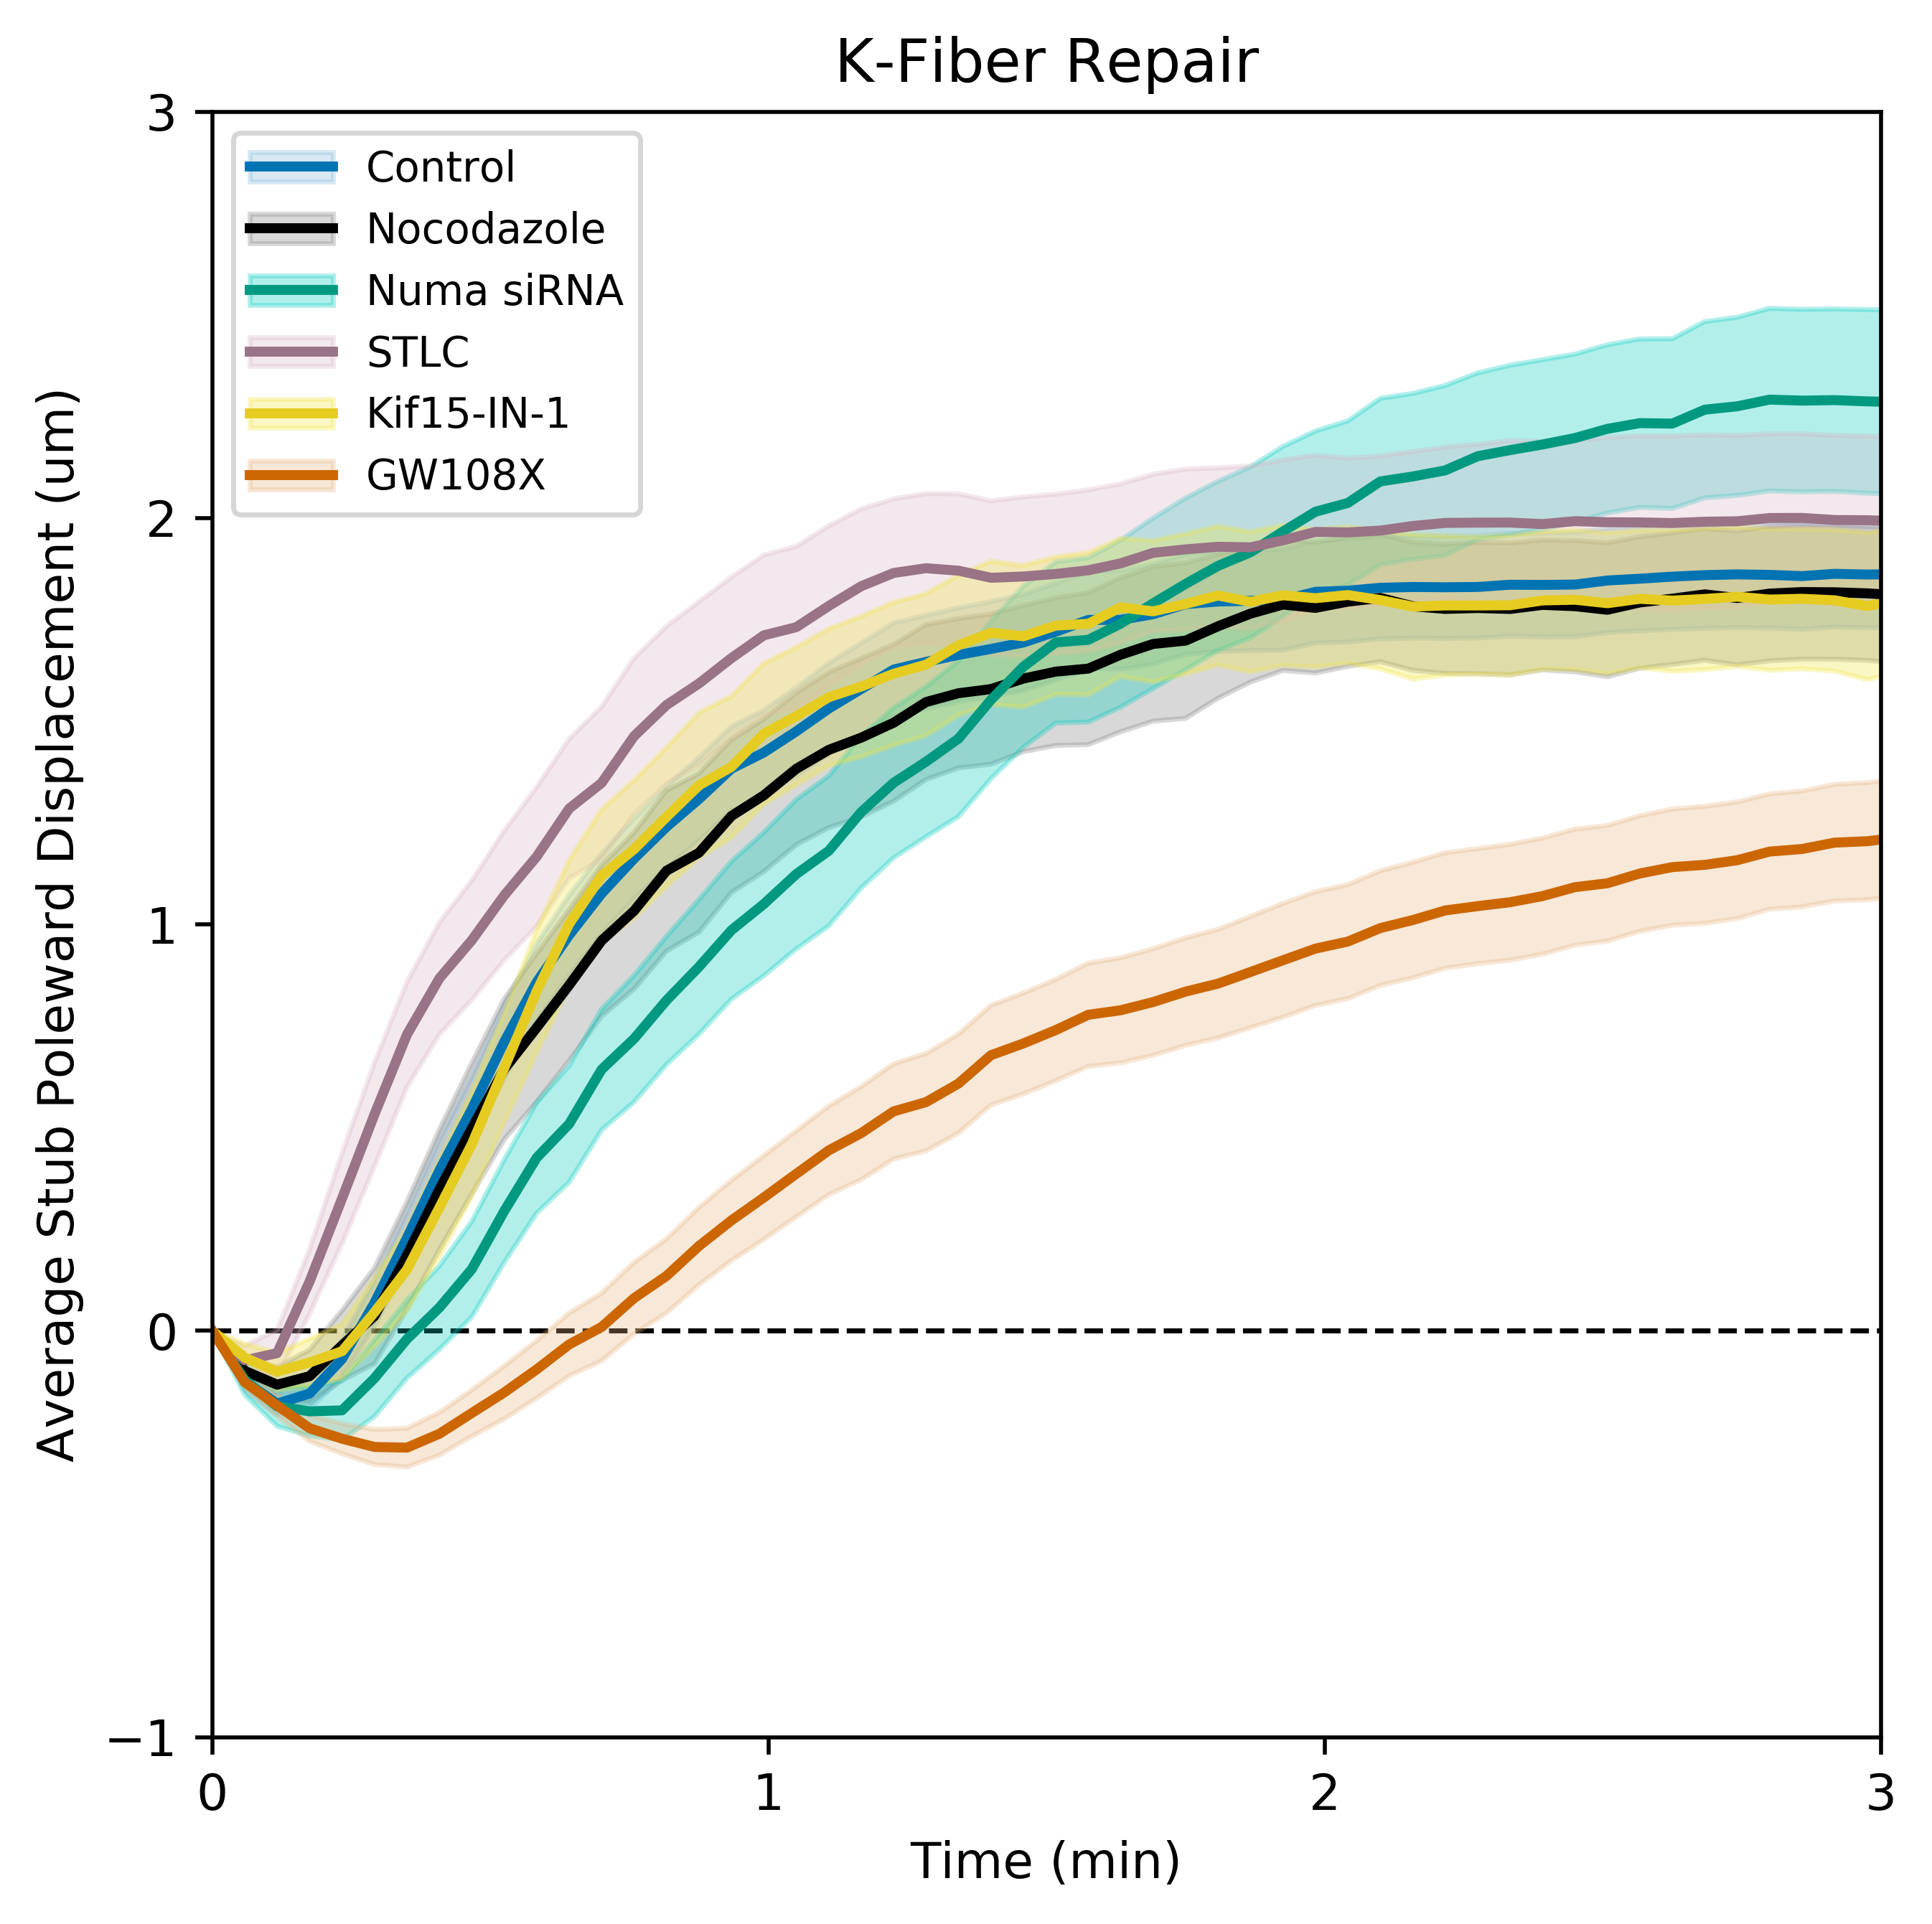

In [6]:
plt.figure(dpi=500, figsize=[6,6])
lineWT, = plt.plot(tTimesD[0], tAvgDs[0], color=colors[0], lw=2, zorder=2)
patchWT = pchs.Patch(color=boxColors[0], alpha=0.3)
lineNDZ, = plt.plot(tTimesD[1], tAvgDs[1], color=colors[1], lw=2, zorder=2)
patchNDZ = pchs.Patch(color=boxColors[1], alpha=0.3)
lineNuMA, = plt.plot(tTimesD[2], tAvgDs[2], color=colors[2], lw=2, zorder=2)
patchNuMA = pchs.Patch(color=boxColors[2], alpha=0.3)
lineSTLC, = plt.plot(tTimesD[3], tAvgDs[3], color=colors[3], lw=2, zorder=2)
patchSTLC = pchs.Patch(color=boxColors[3], alpha=0.3)
lineKN1, = plt.plot(tTimesD[4], tAvgDs[4], color=colors[4], lw=2, zorder=2)
patchKN1 = pchs.Patch(color=boxColors[4], alpha=0.3)
lineK647, = plt.plot(tTimesD[5], tAvgDs[5], color=colors[5], lw=2, zorder=2)
patchK647 = pchs.Patch(color=boxColors[5], alpha=0.3)
for i in range(6):
    plt.fill_between(tTimesD[i], tLowDs[i], tHighDs[i], color=boxColors[i], alpha=0.3, zorder=1)
plt.plot([0,3], [0,0], color='black', lw=1, ls='--', zorder=0)
plt.xlim(0,3)
plt.xticks([0,1,2,3])
plt.ylim(-1,3)
plt.yticks([-1,0,1,2,3])
plt.title('K-Fiber Repair')
plt.xlabel('Time (min)')
plt.ylabel('Average Stub Poleward Displacement (um)')
legs = ((patchWT,lineWT), (patchNDZ,lineNDZ), (patchNuMA,lineNuMA), (patchSTLC,lineSTLC), (patchKN1,lineKN1), (patchK647,lineK647))
plt.legend(legs, names, loc='upper left', fontsize='small')
plt.savefig('S1D.eps', format='eps', dpi=1000)
#plt.close()
for i in range(6):
    print(len(dckds[i]))